## BWAS_Python
In this notebook, I go through an example of how to do Brain-wide association studies (BWAS) in Python. In particular, to compare c-fos cell counts across multiple brain regions across treatment groups. I use two methods: linear regression and negative binomial regression.

This is an attempt to reproduce the results by Will Townes performed in R for Jess Verpeut's 2021 Cell Reports paper. See his (potentially still private) repo: https://github.com/willtownes/neuro (contact at ftownes@princeton.edu).

**NB:** For linear regression, the results are nearly identical between Python and R. For negative binomial regression, the standard error estimates are quite different between Python and R. The estimates themselves are relatively consistent, however. A detailed comparison between these two methods has not been done, nor is it well understood.

- Author: Austin Hoag (with massive help from Will Townes)
- Date: August 25, 2021

In [115]:
import statsmodels.api as sm
import statsmodels.formula.api as smf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from patsy import dmatrix

## Example using whole-brain c-fos cell counts

In [116]:
data_file = '../data/Jess_cfos_total_and_fractional_counts-total_122_regions.csv'

In [117]:
df = pd.read_csv(data_file)
df

,brain,batch,condition,Anterior amygdalar area,Basolateral amygdalar nucleus,Central amygdalar nucleus,Cortical amygdalar area,Intercalated amygdalar nucleus,Lateral amygdalar nucleus,Posterior amygdalar nucleus,...,Supragenual nucleus,Supratrigeminal nucleus,Tegmental reticular nucleus,Motor nucleus of trigeminal,Laterodorsal tegmental nucleus,Nucleus incertus,Pontine reticular nucleus,Nucleus raphe pontis,Subceruleus nucleus,Sublaterodorsal nucleus
0,an011,202010_cfos,acquisition_day1,156,2173,2163,736,160,601,293,...,0,263,223,137,221,95,619,31,54,40
1,an012,202010_cfos,acquisition_day1,350,2327,1595,781,224,816,292,...,0,98,165,225,166,36,870,45,14,31
2,an013,202010_cfos,acquisition_day1,569,2517,1224,824,153,704,521,...,0,235,365,183,221,85,834,111,93,64
3,an014,202010_cfos,acquisition_day1,688,2051,1224,523,169,1076,514,...,0,149,224,143,157,106,864,120,17,50
4,an015,202010_cfos,acquisition_day1,150,1452,608,330,100,417,304,...,0,144,272,119,149,51,660,56,25,208
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
164,dadult_pc_crus1_1,201810_adultacutePC_ymaze_cfos,vector_control_reversal,131,311,264,300,18,167,109,...,0,0,0,0,15,0,142,0,0,0
165,dadult_pc_crus1_3,201810_adultacutePC_ymaze_cfos,vector_control_reversal,123,512,298,494,19,113,243,...,0,0,0,0,0,0,110,0,0,0
166,dadult_pc_crus1_4,201810_adultacutePC_ymaze_cfos,vector_control_reversal,99,279,142,143,4,91,40,...,0,0,0,0,0,0,3,0,0,0
167,dadult_pc_lob6_14,201810_adultacutePC_ymaze_cfos,vector_control_reversal,69,711,281,363,28,175,104,...,0,0,0,0,0,0,0,0,0,0


In [118]:
# Split predictor variables (batch, condition) from count information
all_predictors = df[['batch','condition']]
all_counts = df.iloc[:,3:]

## Example: CNO_control_reversal (control) vs. CNOnCrusILT (treatment)

The null hypothesis is that c-fos counts are drawn from the same distribution in both of these groups, across all brain regions. We can test this on individual brain regions and also across all brain regions. If doing the latter, we must control for false discovery rate, which we can do with the Benjamini-Hochberg method (see below).  

In [119]:
# Find all entries from either conditon
condition1 = 'CNO_control_reversal'
condition2 = 'CNOnCrusILT'
condition_mask = (all_predictors['condition']==condition1) | (all_predictors['condition']==condition2)
predictors = all_predictors.loc[condition_mask,:]
counts = all_counts.loc[condition_mask,:]

In [120]:
counts.shape

(40, 122)

In [121]:
predictors.shape

(40, 2)

In [122]:
predictors

,batch,condition
38,201904_ymaze_cfos,CNO_control_reversal
39,201904_ymaze_cfos,CNO_control_reversal
40,201904_ymaze_cfos,CNO_control_reversal
41,201904_ymaze_cfos,CNO_control_reversal
42,201904_ymaze_cfos,CNO_control_reversal
43,201904_ymaze_cfos,CNO_control_reversal
44,201904_ymaze_cfos,CNO_control_reversal
45,201904_ymaze_cfos,CNO_control_reversal
46,201904_ymaze_cfos,CNO_control_reversal
47,201904_ymaze_cfos,CNO_control_reversal


Can see that we have 3 batches here and 2 conditions

In [123]:
# Use Paty's neat dmatrix() function to create the "design matrix"
# This converts the batch and condition values which are categorical in nature\
# into numeric values
# 
# We only need to do this once per batch/condition combo 
design_matrix = dmatrix("batch + condition", predictors,return_type='dataframe')

In [124]:
design_matrix

,Intercept,batch[T.201908_tpham_ymaze_cfos],batch[T.202002_cfos],condition[T.CNOnCrusILT]
38,1.0,0.0,0.0,0.0
39,1.0,0.0,0.0,0.0
40,1.0,0.0,0.0,0.0
41,1.0,0.0,0.0,0.0
42,1.0,0.0,0.0,0.0
43,1.0,0.0,0.0,0.0
44,1.0,0.0,0.0,0.0
45,1.0,0.0,0.0,0.0
46,1.0,0.0,0.0,0.0
47,1.0,0.0,0.0,0.0


Notice how there are only two batch columns but we started with three batches. That is because If both batch columns here are 0 then the membership is to the third batch. Also note the intercept column which was automatically added. 

In [125]:
# Do the test for an example brain region
subdf = pd.concat([predictors,counts],axis=1)
brain_regions = subdf.columns[2:]
brain_region = brain_regions[0]

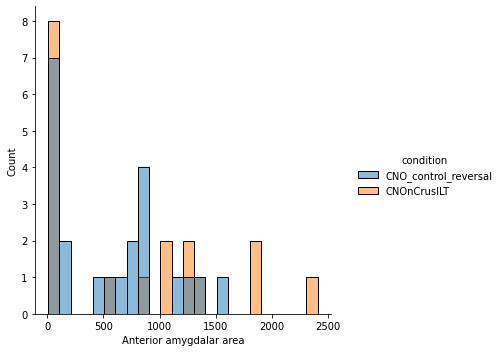

In [126]:
sns.displot(subdf, x=brain_region, hue="condition",binwidth=100)

## Linear regression

In [127]:
# Figure out the fractional counts in this brain region
rowsums=np.sum(counts,axis=1)
counts_thisregion = counts[brain_region]
pcounts = counts_thisregion/rowsums

In [128]:
# Make the Linear Regression model and fit it
mod = sm.OLS(pcounts,design_matrix)
res_LR = mod.fit()

In [129]:
# Print out a summary of the fit
res_LR.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.430
Model:                            OLS   Adj. R-squared:                  0.383
Method:                 Least Squares   F-statistic:                     9.055
Date:                Thu, 02 Sep 2021   Prob (F-statistic):           0.000133
Time:                        12:58:34   Log-Likelihood:                 236.94
No. Observations:                  40   AIC:                            -465.9
Df Residuals:                      36   BIC:                            -459.1
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
====================================================================================================
                                       coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------------
Intercept                            0.0018      0.000      8.194      0.000       0.001       0.002
batch[T.201908_tpham_ymaze_cfos]    -0.0001      0.000     -0.461      0.648      -0.001       0.000
batch[T.202002_cfos]                 0.0010      0.000      3.093      0.004       0.000       0.002
condition[T.CNOnCrusILT]             0.0002      0.000      0.622      0.538      -0.000       0.001
==============================================================================
Omnibus:                        0.025   Durbin-Watson:                   2.210
Prob(Omnibus):                  0.987   Jarque-Bera (JB):                0.177
Skew:                           0.049   Prob(JB):                        0.915
Kurtosis:                       2.690   Cond. No.                         5.42
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [41]:
# Extract the coefficient from the treatment regressor (the last one in the list)
res_LR.params[-1]

0.00015966063027404834

In [42]:
# Extract the standard error from the treament regressor
res_LR.bse[-1]

0.00025671740731887286

In [43]:
# Extract p-value from the treatment regressor
res_LR.pvalues[-1]

0.5379061137767468

In [167]:
p=res_LR.params

In [138]:
residuals = res_LR.resid

In [165]:
resid_df = predictors.copy()
resid_df['pcounts'] = pcounts
resid_df['residuals'] = residuals
resid_df.head(5)

,batch,condition,pcounts,residuals
38,201904_ymaze_cfos,CNO_control_reversal,0.002244,0.000476
39,201904_ymaze_cfos,CNO_control_reversal,0.001028,-0.000741
40,201904_ymaze_cfos,CNO_control_reversal,0.001927,0.000159
41,201904_ymaze_cfos,CNO_control_reversal,0.001625,-0.000143
42,201904_ymaze_cfos,CNO_control_reversal,0.002001,0.000233


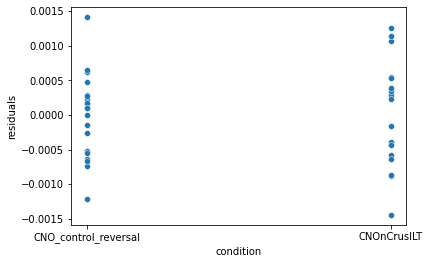

In [157]:
ax = sns.scatterplot(x="condition",y="residuals",data=resid_df)
# ax.plot([pcounts.min(),pcounts.max()],[0,0],'--k')

In [168]:
p

Intercept                           0.001768
batch[T.201908_tpham_ymaze_cfos]   -0.000143
batch[T.202002_cfos]                0.001011
condition[T.CNOnCrusILT]            0.000160
dtype: float64

In [181]:
means

condition
CNO_control_reversal    0.001953
CNOnCrusILT             0.002426
Name: pcounts, dtype: float64

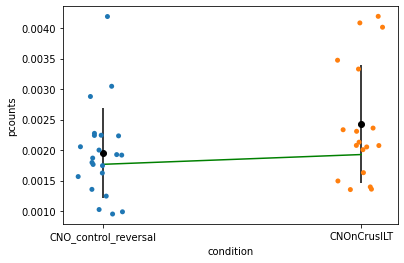

In [183]:
# Compare prediction from model to actual result
# df_thisregion
ax = sns.stripplot(x="condition", y="pcounts", data=resid_df)
means = resid_df.groupby('condition')['pcounts'].mean()
stds = resid_df.groupby('condition')['pcounts'].std()
x=np.array([0,1])
# x2=np.array([1,2])
ax.scatter(x,means,color='k')
ax.errorbar(x,means,yerr=stds, color='k',linestyle="None")
ax.plot(x, p[0] + p[-1] * x,color='g')

## Compare results to using full Patsy formula

In [44]:
# Now apply it to our case
df_thisregion = pd.concat([pcounts,predictors],axis=1).rename(
    columns={0:'AAA'})
mod_fullformula = smf.ols(formula='AAA ~ batch + condition', data=df_thisregion)

In [45]:
fit_fullformula = mod_fullformula.fit()

In [46]:
fit_fullformula.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    AAA   R-squared:                       0.430
Model:                            OLS   Adj. R-squared:                  0.383
Method:                 Least Squares   F-statistic:                     9.055
Date:                Thu, 02 Sep 2021   Prob (F-statistic):           0.000133
Time:                        09:55:41   Log-Likelihood:                 236.94
No. Observations:                  40   AIC:                            -465.9
Df Residuals:                      36   BIC:                            -459.1
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
====================================================================================================
                                       coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------------
Intercept                            0.0018      0.000      8.194      0.000       0.001       0.002
batch[T.201908_tpham_ymaze_cfos]    -0.0001      0.000     -0.461      0.648      -0.001       0.000
batch[T.202002_cfos]                 0.0010      0.000      3.093      0.004       0.000       0.002
condition[T.CNOnCrusILT]             0.0002      0.000      0.622      0.538      -0.000       0.001
==============================================================================
Omnibus:                        0.025   Durbin-Watson:                   2.210
Prob(Omnibus):                  0.987   Jarque-Bera (JB):                0.177
Skew:                           0.049   Prob(JB):                        0.915
Kurtosis:                       2.690   Cond. No.                         5.42
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

This method gives the same results as the method where we precompute the design matrix. Because we will be running this regression for many brain regions and each region has the same predictors, we can use the same design matrix for all regressions. Therefore, it will be faster to use the first method so we will stick with that.

## Negative binomial regression
Here we use total counts instead of fractional counts but must calculate an offset which is the log of the row sums to include in the regression. Otherwise the inputs to the regression are the same. We can use that same design matrix.

Here is a good explanation to help interpret the outputs of the model (see below): https://stats.idre.ucla.edu/sas/output/negative-binomial-regression/

In [47]:
offsets = np.log(rowsums)

In [48]:
# Make the negative binomial model and fit it
nb_mod = sm.GLM(counts_thisregion, design_matrix,
                family=sm.families.NegativeBinomial(),offset=offsets)
nb_fit = nb_mod.fit()

In [49]:
# Print out a summary of the fit, you can extract the fit parameters in the exact same way
# as we did for the linear model
nb_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                    Generalized Linear Model Regression Results                    
===================================================================================
Dep. Variable:     Anterior amygdalar area   No. Observations:                   40
Model:                                 GLM   Df Residuals:                       36
Model Family:             NegativeBinomial   Df Model:                            3
Link Function:                         log   Scale:                          1.0000
Method:                               IRLS   Log-Likelihood:                -259.07
Date:                     Thu, 02 Sep 2021   Deviance:                       3.1382
Time:                             09:55:58   Pearson chi2:                     2.87
No. Iterations:                          7                                         
Covariance Type:                 nonrobust                                         
====================================================================================================
                                       coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------------------
Intercept                           -6.3377      0.317    -20.022      0.000      -6.958      -5.717
batch[T.201908_tpham_ymaze_cfos]    -0.0741      0.460     -0.161      0.872      -0.976       0.828
batch[T.202002_cfos]                 0.4390      0.481      0.912      0.362      -0.504       1.382
condition[T.CNOnCrusILT]             0.0758      0.381      0.199      0.842      -0.671       0.823
====================================================================================================
"""

In [50]:
# Do I get the same result if I fix alpha=1
# Make the negative binomial model and fit it
nb_mod_fixedalpha = sm.GLM(counts_thisregion, design_matrix,
                family=sm.families.NegativeBinomial(),offset=offsets,
                          alpha=1)
nb_fit_fixedalpha = nb_mod_fixedalpha.fit()

In [51]:
nb_fit_fixedalpha.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                    Generalized Linear Model Regression Results                    
===================================================================================
Dep. Variable:     Anterior amygdalar area   No. Observations:                   40
Model:                                 GLM   Df Residuals:                       36
Model Family:             NegativeBinomial   Df Model:                            3
Link Function:                         log   Scale:                          1.0000
Method:                               IRLS   Log-Likelihood:                -259.07
Date:                     Thu, 02 Sep 2021   Deviance:                       3.1382
Time:                             09:57:33   Pearson chi2:                     2.87
No. Iterations:                          7                                         
Covariance Type:                 nonrobust                                         
====================================================================================================
                                       coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------------------
Intercept                           -6.3377      0.317    -20.022      0.000      -6.958      -5.717
batch[T.201908_tpham_ymaze_cfos]    -0.0741      0.460     -0.161      0.872      -0.976       0.828
batch[T.202002_cfos]                 0.4390      0.481      0.912      0.362      -0.504       1.382
condition[T.CNOnCrusILT]             0.0758      0.381      0.199      0.842      -0.671       0.823
====================================================================================================
"""

YES the results are the same! That means the original one fixes alpha. We do NOT want to do this. We fant to fit for alpha. 

In [53]:
# Make sure we get the same result as the full patsy formula
# Now apply it to our case
df_thisregion = pd.concat([counts_thisregion,predictors],axis=1).rename(
    columns={'Anterior amygdalar area':'AAA'})
nb_mod_fullformula = smf.glm(formula='AAA ~ batch + condition', data=df_thisregion,
                         family=sm.families.NegativeBinomial(),offset=offsets)

In [54]:
nb_fit_fullformula = nb_mod_fullformula.fit()

In [55]:
nb_fit_fullformula.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                    AAA   No. Observations:                   40
Model:                            GLM   Df Residuals:                       36
Model Family:        NegativeBinomial   Df Model:                            3
Link Function:                    log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -259.07
Date:                Thu, 02 Sep 2021   Deviance:                       3.1382
Time:                        09:58:24   Pearson chi2:                     2.87
No. Iterations:                     7                                         
Covariance Type:            nonrobust                                         
====================================================================================================
                                       coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------------------
Intercept                           -6.3377      0.317    -20.022      0.000      -6.958      -5.717
batch[T.201908_tpham_ymaze_cfos]    -0.0741      0.460     -0.161      0.872      -0.976       0.828
batch[T.202002_cfos]                 0.4390      0.481      0.912      0.362      -0.504       1.382
condition[T.CNOnCrusILT]             0.0758      0.381      0.199      0.842      -0.671       0.823
====================================================================================================
"""

Again, we get the exact same results. Let's try a different syntax which allegedly allows for fitting for alpha: https://stackoverflow.com/questions/44398081/statsmodels-negative-binomial-doesnt-converge-while-glm-does-converge

In [56]:
nb_mod_fullformula_freealpha = smf.negativebinomial(
    formula='AAA ~ batch + condition', data=df_thisregion,
    offset=offsets)

In [57]:
nb_fit_fullformula_freealpha = nb_mod_fullformula_freealpha.fit()

Optimization terminated successfully.
         Current function value: 5.613482
         Iterations: 12
         Function evaluations: 17
         Gradient evaluations: 17


In [58]:
nb_fit_fullformula_freealpha.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                     NegativeBinomial Regression Results                      
==============================================================================
Dep. Variable:                    AAA   No. Observations:                   40
Model:               NegativeBinomial   Df Residuals:                       36
Method:                           MLE   Df Model:                            3
Date:                Thu, 02 Sep 2021   Pseudo R-squ.:                 0.04885
Time:                        09:59:59   Log-Likelihood:                -224.54
converged:                       True   LL-Null:                       -236.07
Covariance Type:            nonrobust   LLR p-value:                 3.917e-05
====================================================================================================
                                       coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------------------
Intercept                           -6.3375      0.085    -74.157      0.000      -6.505      -6.170
batch[T.201908_tpham_ymaze_cfos]    -0.0627      0.136     -0.460      0.646      -0.330       0.205
batch[T.202002_cfos]                 0.4398      0.133      3.312      0.001       0.180       0.700
condition[T.CNOnCrusILT]             0.0742      0.112      0.661      0.508      -0.146       0.294
alpha                                0.0711      0.017      4.077      0.000       0.037       0.105
====================================================================================================
"""

This is extremely close to Will's result in R! OK so how to do this while using a design matrix but not full formula (for performance so I don't have to calculate the design matrix for each brain region).

# Arbitrary conditions, looping over all brain regions
Here we will write a function that can accept any two conditions and will run regressions over all brain regions for all animals in all batches of those two conditions.

We will calculate adjusted p-values using the Benjamini-Hochberg method since we will be running N tests, where N is the number of brain regions.

In [63]:
def bh_correction(p_values):
    """ 
    ---DESCRIPTION---
    Benjamini-Hochberg correction of p-values
    This is not well tested. 
    ---INPUT---
    p_values:           a list of p-values, can be unsorted but must not have nans
    ---OUTPUT---
    adjusted_p_values:  a list of adjusted p-values sorted from lowest to highest
    """
    # sort the p-values
    sorted_p_values = sorted(p_values)
    # Make an empty array to fill in
    adjusted_p_values = np.zeros_like(sorted_p_values)
    # Fill them from highest to lowest
    # First adjusted p-value is just highest p-value
    adjusted_p_values[-1] = sorted_p_values[-1]
    for p_value_index in range(len(sorted_p_values)-2,-1,-1):
        next_highest = adjusted_p_values[p_value_index+1]
        rank_current = p_value_index+1
        mod_current = sorted_p_values[p_value_index] * (len(sorted_p_values)/rank_current)
        adjusted_p_value = min(next_highest,mod_current)
        adjusted_p_values[p_value_index] = adjusted_p_value
    return adjusted_p_values

In [64]:
def linear_regression(df,condition1,condition2):
    """ 
    ---DESCRIPTION---
    Perform linear regression between condition1 (assumed to be control) and
    condition2 (assumed to be treatment). Uses all batches found in both conditions.
    This is not well tested.
    ---INPUT---
    df:           an NxK dataframe where N rows are the animals and K are the columns, 
                  which must contain the batch, condition and counts in each brain region
    condition1:   a string describing one of the conditions in the dataframe (the control)
    condition2:   a string describing one of the conditions in the dataframe (the treatment)
    ---OUTPUT--
    lr_df:        A dataframe containing the results from the regression on all brain regions in df
    Also Saves to a CSV file called: '../data/{condition1}-{condition2}-pcounts-linreg.csv'
    """
    all_predictors = df[['batch','condition']]
    all_counts = df.iloc[:,3:]
    brain_regions = df.columns[3:]
    
    condition_mask = (all_predictors['condition']==condition1) | (all_predictors['condition']==condition2)
    predictors = all_predictors.loc[condition_mask,:]
    design_matrix = dmatrix("batch + condition", predictors,return_type='dataframe')
    counts = all_counts.loc[condition_mask,:]
    rowsums=np.sum(counts,axis=1)
    result_list = []
    for ii in range(len(brain_regions)):
        brain_region=brain_regions[ii]
        result_dict = {
            'region_idx':ii,
            'control':condition1,
            'treatment':condition2,
            'region':brain_region
        }
        counts_thisregion = counts[brain_region]
        pcounts = counts_thisregion/rowsums
        res_LR = sm.OLS(pcounts,design_matrix).fit()
        estimate = res_LR.params[-1]
        stderr = res_LR.bse[-1]
        pvalue = res_LR.pvalues[-1]
        zscore = estimate/stderr
        if np.isnan(zscore) or np.isnan(pvalue):
            status="failed"
        else:
            status="success"
        result_dict['Estimate'] = estimate
        result_dict['Std. Error'] = stderr
        result_dict['t value'] = zscore
        result_dict['Pr(>|z|)'] = pvalue
        result_dict['status'] = status
        result_list.append(result_dict)
    # Now calculate adjusted pvalues
    # First sort the whole result_list by p-value, keeping in mind that there can be nans
    sorted_result_list = sorted(result_list,
            key=lambda x: float('-inf') if np.isnan(x.get('Pr(>|z|)')) else x.get('Pr(>|z|)')) 
    sorted_p_values = np.array([d.get('Pr(>|z|)') for d in sorted_result_list])
    # separate out nans (which are at the beginning of the list due to how we sorted)
    p_values_clean = sorted_p_values[~np.isnan(sorted_p_values)]
    p_values_nan = sorted_p_values[np.isnan(sorted_p_values)]
    # calculate the fdr adjusted p-values
    adjusted_p_values_no_nans = bh_correction(p_values_clean)
    # add back the nans to the beginning of the list
    adj_p_values = np.concatenate([p_values_nan,adjusted_p_values_no_nans])
    # add the fdr adjusted p-value into the list of our results
    for ii in range(len(sorted_result_list)):
        sorted_result_list[ii]['fdr_adj_pval'] = adj_p_values[ii]
    # Finally, sort back to original order, the one using brain region index as key
    final_result_list = sorted(sorted_result_list,key=lambda x: x.get('region_idx'))
    # Make pandas dataframe to make it easier to save to file
    lr_df = pd.DataFrame(final_result_list)
    lr_df.set_index('region_idx',inplace=True)
    # reorder columns
    neworder = ['control','treatment','region','Estimate','Std. Error','t value','Pr(>|z|)','fdr_adj_pval','status']
    lr_df=lr_df.reindex(columns=neworder)
    # Save to csv
    savename = f'../data/{condition1}-{condition2}-pcounts-linreg.csv'
    lr_df.to_csv(savename,index=False)
    print(f"Saved {savename}")
    return lr_df

In [65]:
lr_df = linear_regression(df=df,condition1 = 'CNO_control_reversal',condition2 = 'CNOnCrusILT')

Saved ../data/CNO_control_reversal-CNOnCrusILT-pcounts-linreg.csv


<ipython-input-64-0d4154d7e782>:40: RuntimeWarning: invalid value encountered in double_scalars
  zscore = estimate/stderr
<ipython-input-64-0d4154d7e782>:40: RuntimeWarning: invalid value encountered in double_scalars
  zscore = estimate/stderr
<ipython-input-64-0d4154d7e782>:40: RuntimeWarning: invalid value encountered in double_scalars
  zscore = estimate/stderr
<ipython-input-64-0d4154d7e782>:40: RuntimeWarning: invalid value encountered in double_scalars
  zscore = estimate/stderr
<ipython-input-64-0d4154d7e782>:40: RuntimeWarning: invalid value encountered in double_scalars
  zscore = estimate/stderr
<ipython-input-64-0d4154d7e782>:40: RuntimeWarning: invalid value encountered in double_scalars
  zscore = estimate/stderr
<ipython-input-64-0d4154d7e782>:40: RuntimeWarning: invalid value encountered in double_scalars
  zscore = estimate/stderr
<ipython-input-64-0d4154d7e782>:40: RuntimeWarning: invalid value encountered in double_scalars
  zscore = estimate/stderr
<ipython-input-6

In [73]:
def nb_regression(df,condition1,condition2):
    """ 
    ---DESCRIPTION---
    Perform negative binomial regression between condition1 (assumed to be control) and
    condition2 (assumed to be treatment). Uses all batches found in both conditions.
    This is not well tested.
    ---INPUT---
    df:           an NxK dataframe where N rows are the animals and K are the columns, 
                  which must contain the batch, condition and counts in each brain region
    condition1:   a string describing one of the conditions in the dataframe (the control)
    condition2:   a string describing one of the conditions in the dataframe (the treatment)
    ---OUTPUT--
    nb_df:        A dataframe containing the results from the regression on all brain regions in df

    Saves to a CSV file called: '../data/{condition1}-{condition2}-counts-nbreg.csv'
    """
    all_predictors = df[['batch','condition']]
    all_counts = df.iloc[:,3:]
    
    condition_mask = (all_predictors['condition']==condition1) | (all_predictors['condition']==condition2)
    predictors = all_predictors.loc[condition_mask,:]
    design_matrix = dmatrix("batch + condition", predictors,return_type='dataframe')
    counts = all_counts.loc[condition_mask,:]
    # Get rid of regions that don't have any counts in any of the brains in this subset
    good_regions_mask = counts.sum(axis=0)>0
    counts = counts.loc[:,good_regions_mask]
    brain_regions = counts.columns
    rowsums=np.sum(counts,axis=1)
    offsets = np.log(rowsums)
    result_list = []
    for ii in range(len(brain_regions)):
        brain_region=brain_regions[ii]
        result_dict = {
            'region_idx':ii,
            'control':condition1,
            'treatment':condition2,
            'region':brain_region
        }
        counts_thisregion = counts[brain_region]
        counts_thisregion.name = 'count'
        df_thisregion = pd.concat([counts_thisregion,predictors],axis=1)
        try:
#             res_nb = sm.GLM(counts_thisregion, design_matrix,family=sm.families.NegativeBinomial(),offset=offsets).fit()
            res_nb = smf.negativebinomial(
                formula='count ~ batch + condition', data=df_thisregion,
                offset=offsets).fit(disp=0)
            estimate = res_nb.params[-2]
            stderr = res_nb.bse[-2]
            pvalue = res_nb.pvalues[-2]
            zscore = estimate/stderr
            status="success"
        except:
            estimate = np.nan
            stderr = np.nan
            pvalue = np.nan
            zscore = np.nan
            status="failed"
        result_dict['Estimate'] = estimate
        result_dict['Std. Error'] = stderr
        result_dict['z value'] = zscore
        result_dict['Pr(>|z|)'] = pvalue
        result_dict['status'] = status
        result_list.append(result_dict)
#     print(result_list)
    # Now calculate adjusted pvalues
    # First sort the whole result_list by p-value, keeping in mind that there can be nans
    sorted_result_list = sorted(result_list,
            key=lambda x: float('-inf') if np.isnan(x.get('Pr(>|z|)')) else x.get('Pr(>|z|)')) 
    sorted_p_values = np.array([d.get('Pr(>|z|)') for d in sorted_result_list])
    # separate out nans (which are at the beginning of the list due to how we sorted)
    p_values_clean = sorted_p_values[~np.isnan(sorted_p_values)]
    p_values_nan = sorted_p_values[np.isnan(sorted_p_values)]
    # calculate the fdr adjusted p-values
    adjusted_p_values_no_nans = bh_correction(p_values_clean)
    # add back the nans to the beginning of the list
    adj_p_values = np.concatenate([p_values_nan,adjusted_p_values_no_nans])
    # add the fdr adjusted p-value into the list of our results
    for ii in range(len(sorted_result_list)):
        sorted_result_list[ii]['fdr_adj_pval'] = adj_p_values[ii]
    # Finally, sort back to original order, the one using brain region index as key
    final_result_list = sorted(sorted_result_list,key=lambda x: x.get('region_idx'))
    # Make pandas dataframe to make it easier to save to file
    nb_df = pd.DataFrame(final_result_list)
    nb_df.set_index('region_idx',inplace=True)
    # reorder columns
    neworder = ['control','treatment','region','Estimate','Std. Error','z value','Pr(>|z|)','fdr_adj_pval','status']
    nb_df=nb_df.reindex(columns=neworder)
    # Save to csv
    savename = f'../data/{condition1}-{condition2}-counts-nbreg_freealpha.csv'
    nb_df.to_csv(savename,index=False)
    print(f"Saved {savename}")
    return nb_df

In [74]:
nb_df = nb_regression(df=df,condition1 = 'CNO_control_reversal',condition2 = 'CNOnCrusILT')

/home/ahoag/anaconda3/envs/cfos/lib/python3.8/site-packages/statsmodels/discrete/discrete_model.py:2642: RuntimeWarning: divide by zero encountered in log
  llf = coeff + size*np.log(prob) + endog*np.log(1-prob)
/home/ahoag/anaconda3/envs/cfos/lib/python3.8/site-packages/statsmodels/discrete/discrete_model.py:2642: RuntimeWarning: invalid value encountered in multiply
  llf = coeff + size*np.log(prob) + endog*np.log(1-prob)


Saved ../data/CNO_control_reversal-CNOnCrusILT-counts-nbreg_freealpha.csv


In [68]:
# Compare my and Will's results

In [69]:
R_nb_csv = '/home/ahoag/Git/neuro/results/bwas/perturbations/CNO_control_reversal-CNOnCrusILT-counts-nbreg.csv'
R_nb_df = pd.read_csv(R_nb_csv)
R_nb_df

,control,treatment,region,Estimate,Std. Error,z value,Pr(>|z|),fdr_adj_pval,status
0,CNO_control_reversal,CNOnCrusILT,Anterior amygdalar area,0.074179,0.112533,0.659176,0.509783,0.847513,success
1,CNO_control_reversal,CNOnCrusILT,Basolateral amygdalar nucleus,0.035508,0.119136,0.298044,0.765670,0.944020,success
2,CNO_control_reversal,CNOnCrusILT,Central amygdalar nucleus,0.192391,0.122226,1.574062,0.115473,0.553227,success
3,CNO_control_reversal,CNOnCrusILT,Cortical amygdalar area,0.268857,0.187559,1.433458,0.151727,0.667598,success
4,CNO_control_reversal,CNOnCrusILT,Intercalated amygdalar nucleus,0.130168,0.134585,0.967180,0.333454,0.767514,success
...,...,...,...,...,...,...,...,...,...
105,CNO_control_reversal,CNOnCrusILT,Nucleus incertus,-0.055716,0.223258,-0.249557,0.802930,0.960364,success
106,CNO_control_reversal,CNOnCrusILT,Pontine reticular nucleus,0.157044,0.149336,1.051618,0.292975,0.732437,success
107,CNO_control_reversal,CNOnCrusILT,Nucleus raphe pontis,-0.058529,0.247988,-0.236016,0.813420,0.960364,success
108,CNO_control_reversal,CNOnCrusILT,Subceruleus nucleus,0.209244,0.283375,0.738401,0.460271,0.846400,success


In [75]:
nb_df

,control,treatment,region,Estimate,Std. Error,z value,Pr(>|z|),fdr_adj_pval,status
region_idx,,,,,,,,,
0,CNO_control_reversal,CNOnCrusILT,Anterior amygdalar area,0.074179,0.112157,0.661381,0.508368,0.856949,success
1,CNO_control_reversal,CNOnCrusILT,Basolateral amygdalar nucleus,0.035508,0.119301,0.297630,0.765985,0.942787,success
2,CNO_control_reversal,CNOnCrusILT,Central amygdalar nucleus,0.192390,0.122065,1.576129,0.114996,0.581350,success
3,CNO_control_reversal,CNOnCrusILT,Cortical amygdalar area,0.268862,0.188844,1.423724,0.154526,0.679916,success
4,CNO_control_reversal,CNOnCrusILT,Intercalated amygdalar nucleus,0.130169,0.133208,0.977179,0.328480,0.764691,success
...,...,...,...,...,...,...,...,...,...
105,CNO_control_reversal,CNOnCrusILT,Nucleus incertus,-0.055716,0.220648,-0.252510,0.800647,0.959044,success
106,CNO_control_reversal,CNOnCrusILT,Pontine reticular nucleus,0.157043,0.151779,1.034682,0.300818,0.752044,success
107,CNO_control_reversal,CNOnCrusILT,Nucleus raphe pontis,-0.058535,0.245214,-0.238708,0.811332,0.959044,success


In [76]:
merged_nb_df = pd.merge?

In [86]:
merged_nb_df=pd.merge(left=R_nb_df,right=nb_df,on='region',suffixes=('_R','_Python'))

In [87]:
merged_nb_df.head(5)

,control_R,treatment_R,region,Estimate_R,Std. Error_R,z value_R,Pr(>|z|)_R,fdr_adj_pval_R,status_R,control_Python,treatment_Python,Estimate_Python,Std. Error_Python,z value_Python,Pr(>|z|)_Python,fdr_adj_pval_Python,status_Python
0,CNO_control_reversal,CNOnCrusILT,Anterior amygdalar area,0.074179,0.112533,0.659176,0.509783,0.847513,success,CNO_control_reversal,CNOnCrusILT,0.074179,0.112157,0.661381,0.508368,0.856949,success
1,CNO_control_reversal,CNOnCrusILT,Basolateral amygdalar nucleus,0.035508,0.119136,0.298044,0.765670,0.944020,success,CNO_control_reversal,CNOnCrusILT,0.035508,0.119301,0.297630,0.765985,0.942787,success
2,CNO_control_reversal,CNOnCrusILT,Central amygdalar nucleus,0.192391,0.122226,1.574062,0.115473,0.553227,success,CNO_control_reversal,CNOnCrusILT,0.192390,0.122065,1.576129,0.114996,0.581350,success
3,CNO_control_reversal,CNOnCrusILT,Cortical amygdalar area,0.268857,0.187559,1.433458,0.151727,0.667598,success,CNO_control_reversal,CNOnCrusILT,0.268862,0.188844,1.423724,0.154526,0.679916,success
4,CNO_control_reversal,CNOnCrusILT,Intercalated amygdalar nucleus,0.130168,0.134585,0.967180,0.333454,0.767514,success,CNO_control_reversal,CNOnCrusILT,0.130169,0.133208,0.977179,0.328480,0.764691,success


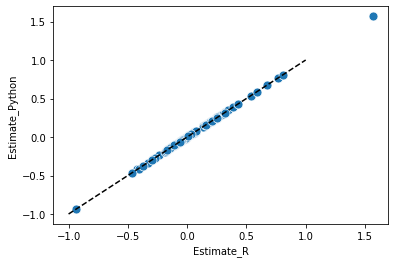

In [114]:
stat = "Estimate"
ax = sns.scatterplot(x="Estimate_R",y="Estimate_Python",data=merged_nb_df,s=80)
ax.plot([-1,1],[-1,1],'--k')
plt.savefig(f"../figs/CNO_control_reversal-CNOnCrusILT_compare_{stat}_R_vs_Python")

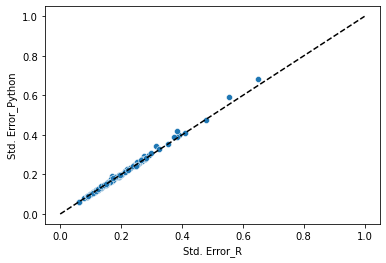

In [108]:
stat = "std_error"
ax = sns.scatterplot(x="Std. Error_R",y="Std. Error_Python",data=merged_nb_df)
ax.plot([0,1],[0,1],'--k')

plt.savefig(f"../figs/CNO_control_reversal-CNOnCrusILT_compare_{stat}_R_vs_Python")

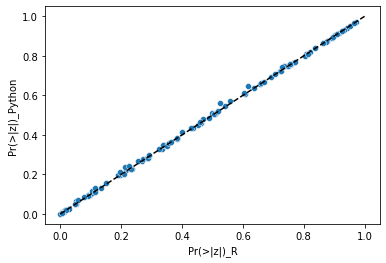

In [107]:
stat = "pval"
ax = sns.scatterplot(x="Pr(>|z|)_R",y="Pr(>|z|)_Python",data=merged_nb_df)
ax.plot([0,1],[0,1],'--k')
plt.savefig(f"../figs/CNO_control_reversal-CNOnCrusILT_compare_{stat}_R_vs_Python")

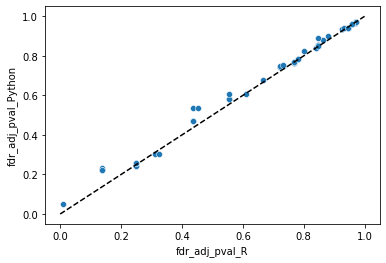

In [105]:
stat = "fdr_adj_pval"
ax = sns.scatterplot(x="fdr_adj_pval_R",y="fdr_adj_pval_Python",data=merged_nb_df)
ax.plot([0,1],[0,1],'--k')
plt.savefig(f"../figs/CNO_control_reversal-CNOnCrusILT_compare_{stat}_R_vs_Python")